In [1]:
import kagglehub

path = kagglehub.dataset_download(
    "kaustubhdikshit/neu-surface-defect-database"
)

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'neu-surface-defect-database' dataset.
Path to dataset files: /kaggle/input/neu-surface-defect-database


In [2]:
!pip install ultralytics opencv-python numpy tqdm scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 55.0 MB/s eta 0:00:00


In [3]:

import os
NEU_ROOT = path+"/NEU-DET"


YOLO_ROOT = "dataset_yolo"


CLASSES = [
    "crazing",
    "inclusion",
    "patches",
    "pitted_surface",
    "rolled-in_scale",
    "scratches"
]

CLASS_MAP = {name: idx for idx, name in enumerate(CLASSES)}

for split in ["train", "val"]:
    os.makedirs(f"{YOLO_ROOT}/images/{split}", exist_ok=True)
    os.makedirs(f"{YOLO_ROOT}/labels/{split}", exist_ok=True)


In [4]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
import glob
import random
import matplotlib.pyplot as plt


In [5]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    return clahe.apply(img)

def motion_blur(img, k=np.random.choice([3, 5, 6])):
    kernel = np.zeros((k, k))
    kernel[k // 2, :] = np.ones(k)
    kernel /= k
    return cv2.filter2D(img, -1, kernel)

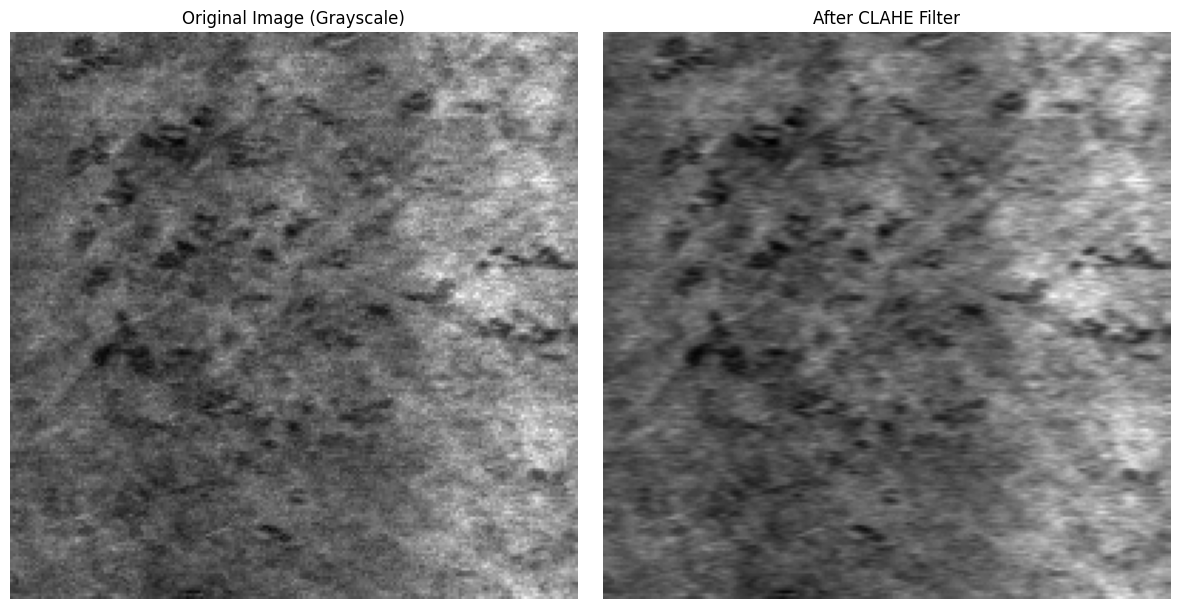

In [6]:
all_images = glob.glob(f"{NEU_ROOT}/train/images/*/rolled-in_scale_225.jpg")

if not all_images:
    print("Not found")
else:
    random_img_path = random.choice(all_images)
    original_img = cv2.imread(random_img_path, cv2.IMREAD_GRAYSCALE)
    processed_img = motion_blur(original_img)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image (Grayscale)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("After CLAHE Filter")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

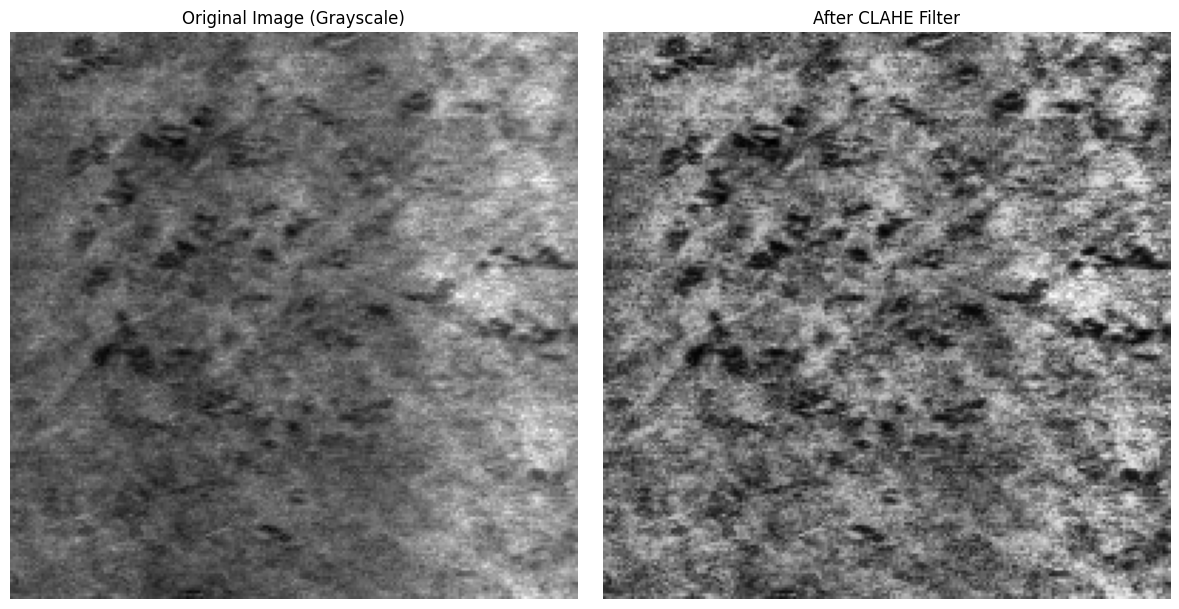

In [7]:
all_images = glob.glob(f"{NEU_ROOT}/train/images/*/rolled-in_scale_225.jpg")

if not all_images:
    print("Not found")
else:
    random_img_path = random.choice(all_images)
    original_img = cv2.imread(random_img_path, cv2.IMREAD_GRAYSCALE)
    processed_img = apply_clahe(original_img)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image (Grayscale)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("After CLAHE Filter")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def voc_to_yolo(xml_path, img_w, img_h):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    labels = []

    for obj in root.findall("object"):
        cls_name = obj.find("name").text
        cls_id = CLASS_MAP[cls_name]

        b = obj.find("bndbox")
        xmin, ymin = float(b.find("xmin").text), float(b.find("ymin").text)
        xmax, ymax = float(b.find("xmax").text), float(b.find("ymax").text)

        xc = ((xmin + xmax) / 2) / img_w
        yc = ((ymin + ymax) / 2) / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h

        labels.append(f"{cls_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    return labels

In [9]:
def process_train():
    img_root = f"{NEU_ROOT}/train/images"
    ann_root = f"{NEU_ROOT}/train/annotations"

    for cls in CLASSES:
        img_dir = f"{img_root}/{cls}"
        if not os.path.exists(img_dir): continue

        for img_name in tqdm(os.listdir(img_dir), desc=f"Processing {cls}"):
            img_path = os.path.join(img_dir, img_name)


            base_name = os.path.splitext(img_name)[0]
            xml_path = os.path.join(ann_root, f"{base_name}.xml")

            if not os.path.exists(xml_path):
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            h, w = img.shape

            img = apply_clahe(img)


            if np.random.rand() < 0.3:
                img = motion_blur(img, k=np.random.choice([3, 5, 7]))

            if np.random.rand() < 0.1:
                sigma = np.random.uniform(2, 10)
                noise = np.random.normal(0, sigma, (h, w)).astype(np.int16)
                img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

            cv2.imwrite(f"{YOLO_ROOT}/images/train/{base_name}.jpg", img)

            labels = voc_to_yolo(xml_path, w, h)
            with open(f"{YOLO_ROOT}/labels/train/{base_name}.txt", "w") as f:
                f.write("\n".join(labels))

In [10]:
def process_val():
    img_root = f"{NEU_ROOT}/validation/images"
    ann_root = f"{NEU_ROOT}/validation/annotations"

    for cls in CLASSES:
        img_dir = f"{img_root}/{cls}"
        if not os.path.exists(img_dir): continue

        for img_name in tqdm(os.listdir(img_dir), desc=f"Val {cls}"):
            img_path = os.path.join(img_dir, img_name)

            base_name = os.path.splitext(img_name)[0]
            xml_path = os.path.join(ann_root, f"{base_name}.xml")

            if not os.path.exists(xml_path):
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            h, w = img.shape

            img = apply_clahe(img)

            cv2.imwrite(f"{YOLO_ROOT}/images/val/{base_name}.jpg", img)

            labels = voc_to_yolo(xml_path, w, h)
            with open(f"{YOLO_ROOT}/labels/val/{base_name}.txt", "w") as f:
                f.write("\n".join(labels))

In [ ]:
print(len(os.listdir(f"{NEU_ROOT}/train/annotations")))
print(len(os.listdir(f"{NEU_ROOT}/validation/annotations")))

1439
361


In [ ]:
process_train()
process_val()
print("Dataset Prepared")

Val scratches: 100%|██████████| 60/60 [00:00<00:00, 73.19it/s]

Dataset Prepared


In [11]:
import shutil

zip_file_name = "NEU_DET_YOLO_Ready"

shutil.make_archive(zip_file_name, 'zip', YOLO_ROOT)


print(f"✅ Saved {zip_file_name}.zip")
print(f" {os.path.getsize(zip_file_name + '.zip') / (1024*1024):.2f} MB")

✅ Saved NEU_DET_YOLO_Ready.zip
 0.00 MB


In [12]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


destination_path = '/content/drive/MyDrive/FINAL_Project/Dataset'
zip_file_name = "NEU_DET_YOLO_Ready.zip"

if not os.path.exists(destination_path):
    os.makedirs(destination_path)
else:
    print(f"Done")
source_file = f"{zip_file_name}"
final_destination = os.path.join(destination_path, zip_file_name)

!cp {source_file} "{final_destination}"

!cp -r {YOLO_ROOT} "{destination_path}"
!cp -r {NEU_ROOT} "{destination_path}"

if os.path.exists(final_destination):
    print(f"Coppied into: {final_destination}")
else:
    print(f"Error")

Done
cp: cannot stat 'NEU_DET_YOLO_Ready.zip': No such file or directory
^C
^C
Coppied into: /content/drive/MyDrive/FINAL_Project/Dataset/NEU_DET_YOLO_Ready.zip


In [13]:
import os
import zipfile

drive_zip_path = '/content/drive/MyDrive/FINAL_Project/Dataset/NEU_DET_YOLO_Ready.zip'
local_zip_path = '/content/dataset_yolo.zip'
extract_to = YOLO_ROOT

if os.path.exists(drive_zip_path):
    !cp "{drive_zip_path}" {local_zip_path}

else:
    print("Not found")

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

!unzip -q {local_zip_path} -d {extract_to}

!ls {extract_to}

images	labels


In [14]:
with open("data.yaml", "w") as f:
    f.write("""
path: dataset_yolo
train: images/train
val: images/val

nc: 6
names:
  - crazing
  - inclusion
  - patches
  - pitted_surface
  - rolled-in_scale
  - scratches
""")


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn.modules import Conv
from ultralytics.utils.loss import BboxLoss
from ultralytics import YOLO

class GSConv(nn.Module):
    def __init__(self, c1, c2, k=3, s=1):
        super().__init__()
        self.cv1 = nn.Conv2d(c1, c2 // 2, k, s, k//2, bias=False)
        self.bn1 = nn.BatchNorm2d(c2 // 2)

        self.dw = nn.Conv2d(c2//2, c2//2, 3, 1, 1,
                            groups=c2//2, bias=False)
        self.pw = nn.Conv2d(c2//2, c2//2, 1, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(c2//2)

    def shuffle(self, x):
        b, c, h, w = x.size()
        x = x.view(b, 2, c//2, h, w)
        x = x.transpose(1,2).contiguous()
        return x.view(b,c,h,w)

    def forward(self,x):
        x1 = F.relu(self.bn1(self.cv1(x)))
        x2 = F.relu(self.bn2(self.pw(self.dw(x1))))
        return self.shuffle(torch.cat([x1,x2],1))


class DualConv(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv3 = nn.Conv2d(c,c,3,1,1,groups=4,bias=False)
        self.conv1 = nn.Conv2d(c,c,1,1,0,bias=False)
        self.bn = nn.BatchNorm2d(c)

    def forward(self,x):
        return F.relu(self.bn(self.conv1(self.conv3(x))))


class CSP_ABAN(nn.Module):
    def __init__(self,c,n=2):
        super().__init__()
        self.c_ = c//2
        self.blocks = nn.Sequential(*[DualConv(self.c_) for _ in range(n)])
        self.cv = nn.Conv2d(c,c,1,1,0,bias=False)
        self.bn = nn.BatchNorm2d(c)

    def forward(self,x):
        x1,x2 = torch.split(x,[self.c_,self.c_],1)
        y = self.blocks(x2)
        return F.relu(self.bn(self.cv(torch.cat([x1,y],1))))


class GAM(nn.Module):
    def __init__(self,c,r=16):
        super().__init__()
        self.channel = nn.Sequential(
            nn.Conv2d(c,c//r,1),
            nn.ReLU(),
            nn.Conv2d(c//r,c,1)
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(c,c//r,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(c//r,c,3,padding=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = x*self.sigmoid(self.channel(x))
        x = x*self.sigmoid(self.spatial(x))
        return x



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [16]:
from ultralytics.utils.loss import BboxLoss
import torch

def piouv2_iou(pred, target, lambda_=1.7):

    x1 = torch.max(pred[:,0], target[:,0])
    y1 = torch.max(pred[:,1], target[:,1])
    x2 = torch.min(pred[:,2], target[:,2])
    y2 = torch.min(pred[:,3], target[:,3])

    inter = (x2-x1).clamp(0)*(y2-y1).clamp(0)

    area1 = (pred[:,2]-pred[:,0])*(pred[:,3]-pred[:,1])
    area2 = (target[:,2]-target[:,0])*(target[:,3]-target[:,1])

    union = area1+area2-inter
    iou = inter/(union+1e-6)

    dw1 = torch.abs(pred[:,0]-target[:,0])
    dw2 = torch.abs(pred[:,2]-target[:,2])
    dh1 = torch.abs(pred[:,1]-target[:,1])
    dh2 = torch.abs(pred[:,3]-target[:,3])

    wgt = target[:,2]-target[:,0]
    hgt = target[:,3]-target[:,1]

    P = (dw1/wgt+dw2/wgt+dh1/hgt+dh2/hgt)/4
    q = torch.exp(-P)

    L_piou = 1-iou+(1-torch.exp(-P**2))
    attention = 3*(lambda_*q)*torch.exp(-(lambda_*q)**2)

    return attention*L_piou


from ultralytics.utils.loss import BboxLoss
import torch

_orig_forward = BboxLoss.forward

def new_forward(self,
                pred_dist,
                pred_bboxes,
                anchor_points,
                target_bboxes,
                target_scores,
                target_scores_sum,
                fg_mask,
                *args,
                **kwargs):

    loss_iou, loss_dfl = _orig_forward(
        self,
        pred_dist,
        pred_bboxes,
        anchor_points,
        target_bboxes,
        target_scores,
        target_scores_sum,
        fg_mask,
        *args,
        **kwargs
    )

    if fg_mask.sum() > 0:
        pred_pos = pred_bboxes[fg_mask]
        target_pos = target_bboxes[fg_mask]

        piou_loss = piouv2_iou(pred_pos, target_pos).mean()
        loss_iou = piou_loss

    return loss_iou, loss_dfl


BboxLoss.forward = new_forward

print("✅ PIoUv2 Successfully Patched for YOLOv8.4.14")


✅ PIoUv2 Successfully Patched for YOLOv8.4.14


In [17]:
from ultralytics.nn.modules.head import Detect
model = YOLO("yolov8n.yaml")

for i,m in enumerate(model.model.model):
    if m.__class__.__name__ == "Conv":
        c1 = m.conv.in_channels
        c2 = m.conv.out_channels
        s  = m.conv.stride[0]
        k  = m.conv.kernel_size[0]
        model.model.model[i] = GSConv(c1, c2, k=k, s=s)


    if m.__class__.__name__ == "C2f":
        c = m.cv2.conv.out_channels
        model.model.model[i] = CSP_ABAN(c)

print("YOLOv8n-GSE Loaded Successfully ✅")

YOLOv8n-GSE Loaded Successfully ✅


In [18]:

model.train(
    data="data.yaml",
    epochs=300,
    imgsz=640,
    batch=16,
    optimizer="AdamW",
    lr0=1e-3,
    lrf=0.01,
    cos_lr=True,
    warmup_epochs=5,

    mosaic=0.0,
    mixup=0.0,
    cutmix=0.0,
    fliplr=0.5,
    flipud=0.5,
    scale=0.3,

    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    patience=100,
    device=0,

    project="/content/drive/MyDrive/FINAL_Project/Training_Results",
    name="YOLO_final"
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=0.0, multi_scale=0.0, name=YOLO_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793851711e50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Getting started ... /content/drive/MyDrive/FINAL_Project/samples


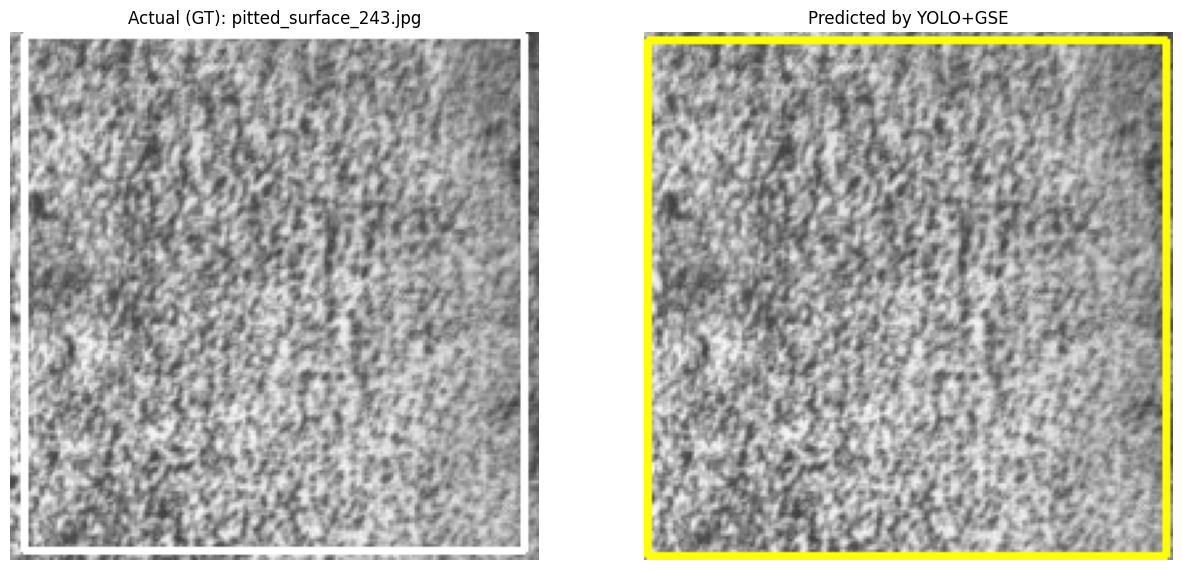

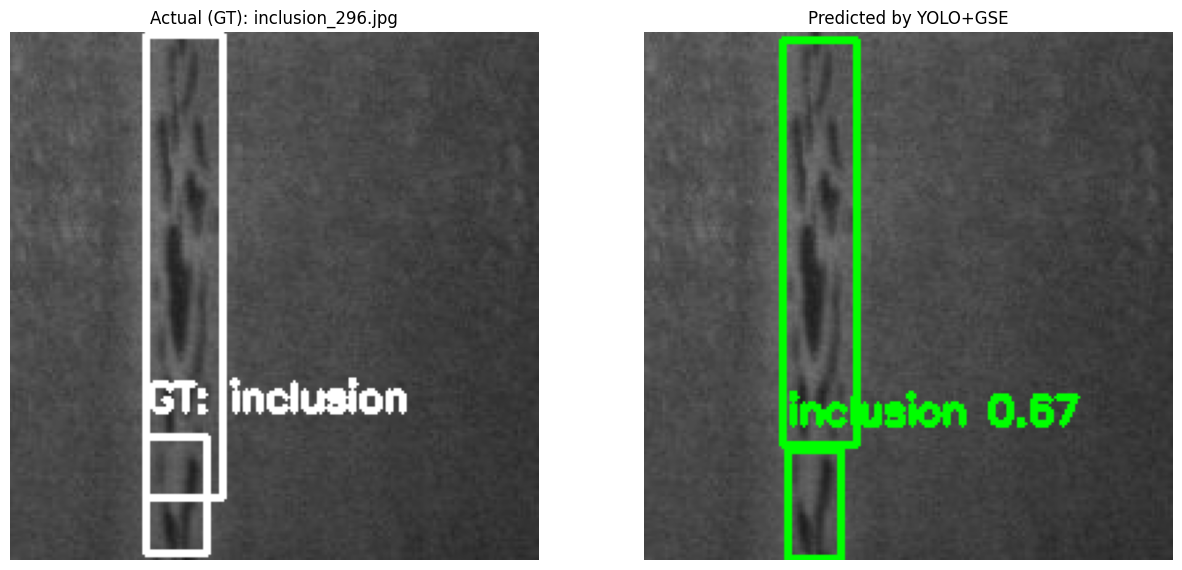

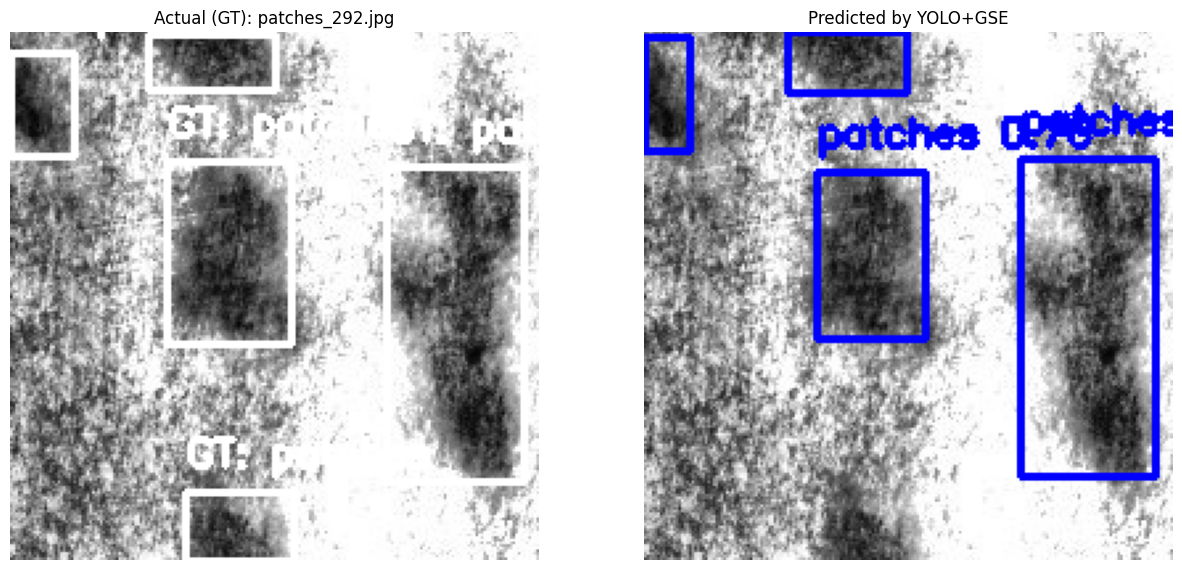

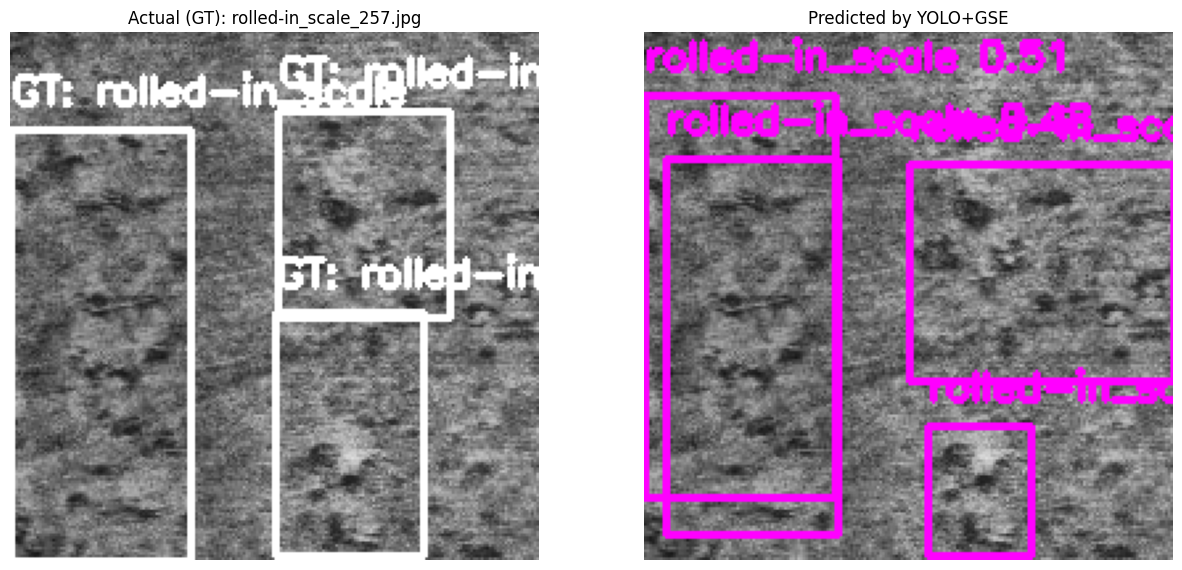

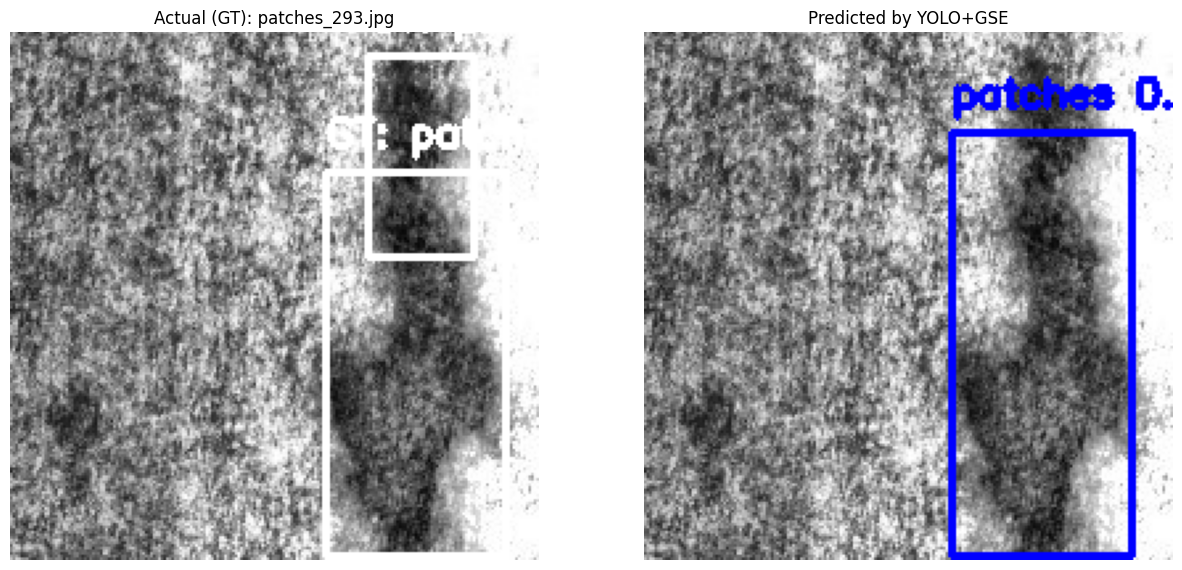

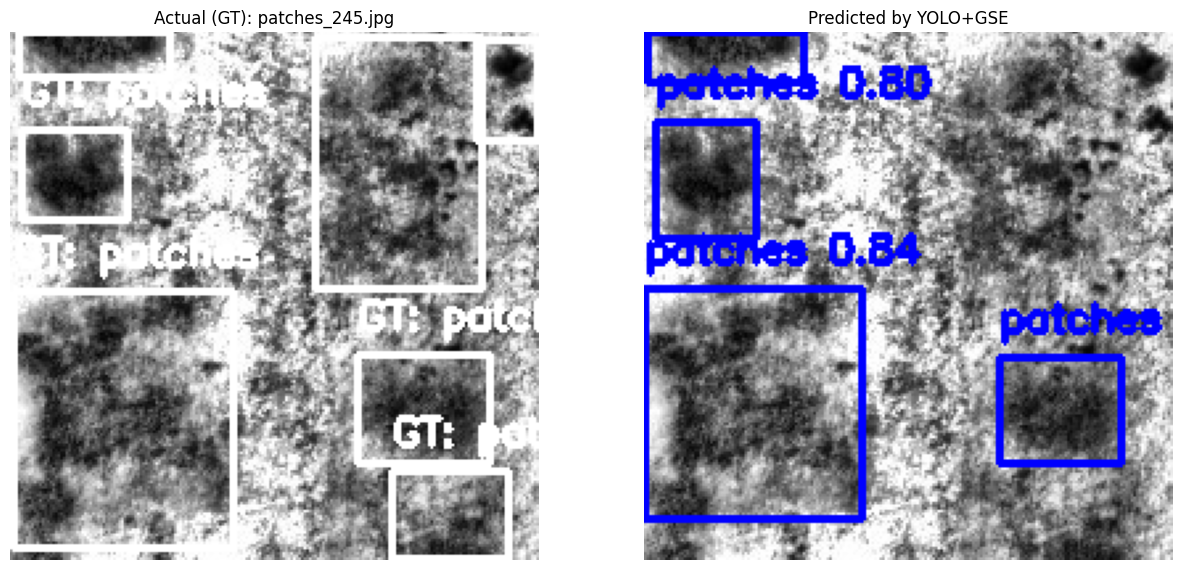

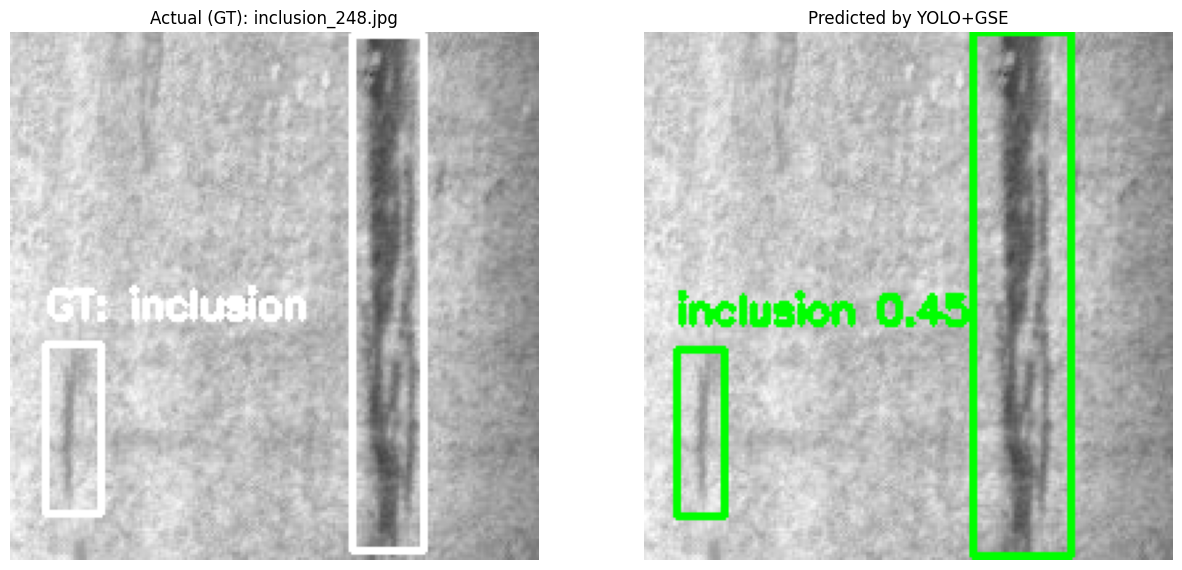

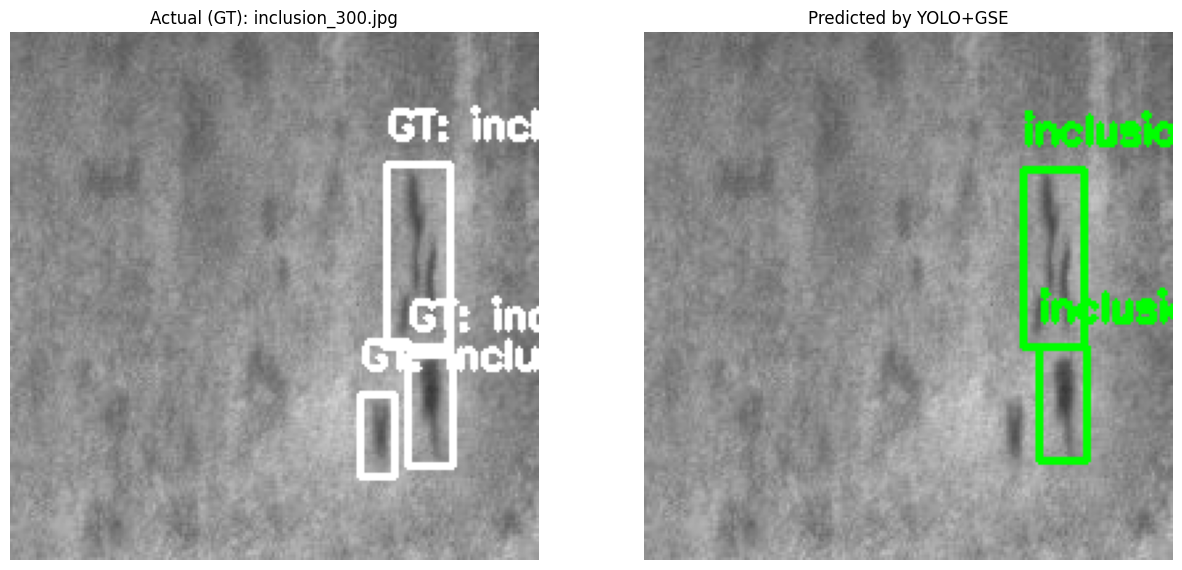

All Images are saved in DRIVE


In [19]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

CLASSES = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]

COLORS = [
    (255, 0, 0),    # red
    (0, 255, 0),    # green
    (0, 0, 255),    # blue
    (255, 255, 0),  # yellow
    (255, 0, 255),  # pink
    (0, 255, 255)   # light blue
]

model_path = "/content/drive/MyDrive/FINAL_Project/Training_Results/YOLO_final/weights/best.pt"
VAL_IMG_DIR = "dataset_yolo/images/val"
VAL_LBL_DIR = "dataset_yolo/labels/val"
SAVE_DIR = "/content/drive/MyDrive/FINAL_Project/samples"

os.makedirs(SAVE_DIR, exist_ok=True)

model = YOLO(model_path)

def draw_yolo_labels(img, label_path):
    h, w, _ = img.shape
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x, y, nw, nh = map(float, line.split())
                x1 = int((x - nw/2) * w)
                y1 = int((y - nh/2) * h)
                x2 = int((x + nw/2) * w)
                y2 = int((y + nh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
                cv2.putText(img, f"GT: {CLASSES[int(cls)]}", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return img

images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.jpg', '.png'))]
sample_count = 8
sample_images = random.sample(images, sample_count)

print(f"Getting started ... {SAVE_DIR}")

for img_name in sample_images:
    img_path = os.path.join(VAL_IMG_DIR, img_name)
    lbl_path = os.path.join(VAL_LBL_DIR, img_name.replace('.jpg', '.txt'))

    original_img = cv2.imread(img_path)
    if original_img is None:
        continue
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    gt_img = draw_yolo_labels(original_img.copy(), lbl_path)

    results = model(img_path, conf=0.4, verbose=False)[0]
    pred_img = original_img.copy()

    for box in results.boxes:
        c = int(box.cls)
        conf = float(box.conf)
        xyxy = box.xyxy[0].cpu().numpy().astype(int)

        class_color = COLORS[c]

        cv2.rectangle(pred_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), class_color, 2)
        cv2.putText(pred_img, f"{CLASSES[c]} {conf:.2f}", (xyxy[0], xyxy[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_color, 2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].imshow(gt_img)
    axes[0].set_title(f"Actual (GT): {img_name}")
    axes[0].axis("off")

    axes[1].imshow(pred_img)
    axes[1].set_title(f"Predicted by YOLO+GSE")
    axes[1].axis("off")

    save_path = os.path.join(SAVE_DIR, img_name)

    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close(fig)


print("All Images are saved in DRIVE")

# Fuzzy

In [20]:
!pip install scikit-fuzzy

In [21]:
SAVE_DIR = "/content/drive/MyDrive/FINAL_Project/Fuzzy_System"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = "/content/drive/MyDrive/FINAL_Project/Training_Results/YOLO_final/weights/best.pt"
VAL_IMG_DIR = "dataset_yolo/images/val"
VAL_LBL_DIR = "dataset_yolo/labels/val"

CLASSES = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]


In [22]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from ultralytics import YOLO


RISK_FACTORS = {
    0: 1.0,  # crazing (High Risk)
    1: 0.9,  # inclusion
    2: 0.6,  # patches
    3: 0.8,  # pitted_surface
    4: 0.5,  # rolled-in_scale
    5: 0.2   # scratches (Low Risk)
}

class AdvancedFuzzyController:
    def __init__(self):

        self.risk_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'risk_score')
        self.confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')
        self.speed_change = ctrl.Consequent(np.arange(-1, 1.01, 0.01), 'speed_change')

        self.risk_score['Low']    = fuzz.gaussmf(self.risk_score.universe, 0, 0.15)
        self.risk_score['Medium'] = fuzz.gaussmf(self.risk_score.universe, 0.5, 0.15)
        self.risk_score['High']   = fuzz.gaussmf(self.risk_score.universe, 1, 0.15)

        self.confidence['Low']    = fuzz.gaussmf(self.confidence.universe, 0, 0.15)
        self.confidence['Medium'] = fuzz.gaussmf(self.confidence.universe, 0.5, 0.15)
        self.confidence['High']   = fuzz.gaussmf(self.confidence.universe, 1, 0.15)

        self.speed_change['Brake']      = fuzz.gaussmf(self.speed_change.universe, -1, 0.25)
        self.speed_change['Maintain']   = fuzz.gaussmf(self.speed_change.universe, 0, 0.15)
        self.speed_change['Accelerate'] = fuzz.gaussmf(self.speed_change.universe, 1, 0.25)

        self.rules = [

            ctrl.Rule(self.risk_score['Low'] & self.confidence['High'], self.speed_change['Accelerate']),
            ctrl.Rule(self.risk_score['Low'] & self.confidence['Medium'], self.speed_change['Accelerate']),
            ctrl.Rule(self.risk_score['Low'] & self.confidence['Low'], self.speed_change['Maintain']),

            ctrl.Rule(self.risk_score['Medium'] & self.confidence['High'], self.speed_change['Brake']),
            ctrl.Rule(self.risk_score['Medium'] & self.confidence['Medium'], self.speed_change['Maintain']),
            ctrl.Rule(self.risk_score['Medium'] & self.confidence['Low'], self.speed_change['Maintain']),

            ctrl.Rule(self.risk_score['High'] & self.confidence['High'], self.speed_change['Brake']),
            ctrl.Rule(self.risk_score['High'] & self.confidence['Medium'], self.speed_change['Brake']),
            ctrl.Rule(self.risk_score['High'] & self.confidence['Low'], self.speed_change['Brake']),
        ]

        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def compute(self, risk_val, conf_val):
        self.simulation.input['risk_score'] = np.clip(risk_val, 0, 1)
        self.simulation.input['confidence'] = np.clip(conf_val, 0, 1)
        self.simulation.compute()
        return self.simulation.output['speed_change']

    def plot_result_manual(self, filename_suffix):

        fig, ax = plt.subplots(figsize=(8, 4))

        x = self.speed_change.universe
        mfs = self.speed_change.terms
        for label, term in mfs.items():
            ax.plot(x, term.mf, label=label)
            ax.fill_between(x, 0, term.mf, alpha=0.1)

        try:
            res = self.simulation.output['speed_change']
            ax.vlines(res, 0, 1, colors='r', linestyles='dashed', linewidth=2, label='Result')
        except:
            pass

        ax.set_title(f"Fuzzy Result: {filename_suffix}")
        ax.legend()

        save_path = os.path.join(SAVE_DIR, f"{filename_suffix}.png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
        print(f"Plots saved: {save_path}")



In [23]:

fuzzy_brain = AdvancedFuzzyController()

scenarios = [
    {"area": 0.85, "conf": 0.90, "name": "Scenario1_HighRisk"},
    {"area": 0.10, "conf": 0.85, "name": "Scenario2_LowRisk"},
    {"area": 0.50, "conf": 0.30, "name": "Scenario3_Ambiguous"}
]

for sc in scenarios:
    res = fuzzy_brain.compute(sc["area"], sc["conf"])
    print(f"Testing {sc['name']}: Risk={sc['area']}, Conf={sc['conf']} --> Speed Change={res:.2f}")
    fname = f"risk_{sc['area']}_conf_{sc['conf']}_result"
    fuzzy_brain.plot_result_manual(fname)

def calculate_weighted_risk(results, img_shape):
    h, w = img_shape[:2]
    total_pixels = h * w
    total_weighted_risk = 0
    confidences = []

    if len(results.boxes) == 0:
        return 0.0, 1.0

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        box_area = (x2 - x1) * (y2 - y1)
        normalized_area = box_area / total_pixels

        cls_id = int(box.cls)
        risk_factor = RISK_FACTORS.get(cls_id, 0.5)

        total_weighted_risk += (normalized_area * risk_factor) * 10
        confidences.append(float(box.conf))

    mean_conf = sum(confidences) / len(confidences)

    return min(total_weighted_risk, 1.0), mean_conf

def draw_gt(img, label_path):
    h, w, _ = img.shape
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x, y, nw, nh = map(float, line.split())
                x1, y1 = int((x - nw/2) * w), int((y - nh/2) * h)
                x2, y2 = int((x + nw/2) * w), int((y + nh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
                cv2.putText(img, f"GT: {CLASSES[int(cls)]}", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    return img

def draw_pred(img, results):
    for box in results.boxes:
        c = int(box.cls)
        conf = float(box.conf)
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        color = COLORS[c]
        cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
        cv2.putText(img, f"{CLASSES[c]} {conf:.2f}", (xyxy[0], xyxy[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img


model = YOLO(MODEL_PATH)
all_images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.jpg', '.png'))]

sample_images = random.sample(all_images, min(3, len(all_images)))

for img_name in sample_images:
    img_path = os.path.join(VAL_IMG_DIR, img_name)
    lbl_path = os.path.join(VAL_LBL_DIR, img_name.replace('.jpg', '.txt'))

    original_img = cv2.imread(img_path)
    if original_img is None: continue
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    results = model(img_path, conf=0.25, verbose=False)[0]

    calc_risk, calc_conf = calculate_weighted_risk(results, original_img.shape)

    fuzzy_output = fuzzy_brain.compute(calc_risk, calc_conf)

    gt_img = draw_gt(original_img.copy(), lbl_path)
    pred_img = draw_pred(original_img.copy(), results)

    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(gt_img)
    ax1.set_title(f"Ground Truth: {img_name}", fontsize=12, fontweight='bold')
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(pred_img)
    ax2.set_title(f"YOLOv8 Detection", fontsize=12, fontweight='bold')
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.axis("off")
    decision_text = 'ACCELERATE'
    if fuzzy_output < -0.1: decision_text = 'BRAKE (Slow Down)'
    elif fuzzy_output < 0.1: decision_text = 'MAINTAIN'

    text_info = (
        f"--- Fuzzy Input Analysis ---\n\n"
        f"1. Weighted Risk Score: {calc_risk:.3f} (0 to 1)\n"
        f"2. Mean Confidence:     {calc_conf*100:.1f}%\n\n"
        f"--- Fuzzy Output Decision ---\n\n"
        f"SPEED CHANGE FACTOR:    {fuzzy_output:.3f}\n"
        f"Decision: {decision_text}"
    )
    ax3.text(0.1, 0.5, text_info, fontsize=14, va='center', ha='left',
             bbox=dict(boxstyle="round,pad=0.5", fc="#f0f0f0", ec="black", alpha=0.9))

    ax4 = fig.add_subplot(gs[1, 1])
    x = fuzzy_brain.speed_change.universe
    mfs = fuzzy_brain.speed_change.terms
    for label, term in mfs.items():
        ax4.plot(x, term.mf, label=label, linewidth=1.5)
        ax4.fill_between(x, 0, term.mf, alpha=0.1)

    ax4.vlines(fuzzy_output, 0, 1, colors='r', linestyles='dashed', linewidth=3, label='Result')
    ax4.set_title("Fuzzy Speed Control Logic", fontsize=12, fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    save_path = os.path.join(SAVE_DIR, img_name)
    plt.savefig(save_path, bbox_inches='tight', dpi=100)
    plt.close(fig)
    print(f"All saved : {save_path}")

print(f"Ouput plots path: \n{SAVE_DIR}")

Testing Scenario1_HighRisk: Risk=0.85, Conf=0.9 --> Speed Change=-0.71
Plots saved: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/risk_0.85_conf_0.9_result.png
Testing Scenario2_LowRisk: Risk=0.1, Conf=0.85 --> Speed Change=0.63
Plots saved: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/risk_0.1_conf_0.85_result.png
Testing Scenario3_Ambiguous: Risk=0.5, Conf=0.3 --> Speed Change=0.00
Plots saved: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/risk_0.5_conf_0.3_result.png
All saved : /content/drive/MyDrive/FINAL_Project/Fuzzy_System/rolled-in_scale_262.jpg
All saved : /content/drive/MyDrive/FINAL_Project/Fuzzy_System/rolled-in_scale_270.jpg
All saved : /content/drive/MyDrive/FINAL_Project/Fuzzy_System/pitted_surface_270.jpg
Ouput plots path: 
/content/drive/MyDrive/FINAL_Project/Fuzzy_System


# create video

In [24]:
import cv2
import os
import numpy as np

IMG_DIR = "dataset_yolo/images/val"
VIDEO_PATH = "/content/raw_simulation.mp4"

fps = 5
frame_size = (640, 640)

images = [img for img in os.listdir(IMG_DIR) if img.endswith(".jpg") or img.endswith(".png")]
images.sort()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(VIDEO_PATH, fourcc, fps, frame_size)

print(f"Creating video from {len(images)} images of validation...")

for img_name in images:
    path = os.path.join(IMG_DIR, img_name)
    frame = cv2.imread(path)
    if frame is not None:
        frame = cv2.resize(frame, frame_size)
        for _ in range(4):
            out.write(frame)

out.release()
print(f"Video created: {VIDEO_PATH}")

destination_dir = "/content/drive/MyDrive/FINAL_Project/simulated_video/"

import shutil
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
    print(f"Created new directory: {destination_dir}")
else:
    print(f"Directory already exists: {destination_dir}")

try:
    shutil.copy(VIDEO_PATH, destination_dir)
    print(f"✅ Video successfully copied to: {destination_dir}")
except Exception as e:
    print(f"❌ Error copying file: {e}")

Creating video from 360 images of validation...
Video created: /content/raw_simulation.mp4
Created new directory: /content/drive/MyDrive/FINAL_Project/simulated_video/
✅ Video successfully copied to: /content/drive/MyDrive/FINAL_Project/simulated_video/


In [25]:
import time
from tqdm import tqdm

INPUT_VIDEO = "/content/drive/MyDrive/FINAL_Project/simulated_video/raw_simulation.mp4"
OUTPUT_VIDEO = "/content/drive/MyDrive/FINAL_Project/Fuzzy_System/smart_conveyor_simulation.mp4"
SAVE_PLOT_PATH = "/content/drive/MyDrive/FINAL_Project/Fuzzy_System/speed_analysis.png"

CURRENT_SPEED = 0.5
MIN_SPEED = 0.1
MAX_SPEED = 1.0
SPEED_INERTIA = 0.1

history_speed = []
history_risk = []
history_conf = []

def apply_motion_blur(image, speed):

    factor = 20
    kernel_size = int(speed * factor)

    if kernel_size < 1:
        return image

    kernel_motion_blur = np.zeros((kernel_size, kernel_size))
    kernel_motion_blur[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel_motion_blur /= kernel_size

    return cv2.filter2D(image, -1, kernel_motion_blur)




In [26]:
fuzzy_brain = AdvancedFuzzyController()
model = YOLO("/content/drive/MyDrive/FINAL_Project/Training_Results/YOLO_final/weights/best.pt")

cap = cv2.VideoCapture(INPUT_VIDEO)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_sim = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))

print(f"Starting closed loop simulation on {total_frames} frames...")

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret: break

    blurred_frame = apply_motion_blur(frame.copy(), CURRENT_SPEED)

    results = model(blurred_frame, conf=0.25, verbose=False)[0]

    risk_score, mean_conf = calculate_weighted_risk(results, frame.shape)

    speed_change_factor = fuzzy_brain.compute(risk_score, mean_conf)

    target_speed = CURRENT_SPEED + (speed_change_factor * 0.1)

    CURRENT_SPEED = np.clip(target_speed, MIN_SPEED, MAX_SPEED)

    history_speed.append(CURRENT_SPEED)
    history_risk.append(risk_score)
    history_conf.append(mean_conf)

    annotated_frame = blurred_frame.copy()
    annotated_frame = draw_pred(annotated_frame, results)


    cv2.rectangle(annotated_frame, (0, 0), (width, 80), (0, 0, 0), -1)

    speed_color = (0, 255, 0) if CURRENT_SPEED > 0.7 else (0, 165, 255) if CURRENT_SPEED > 0.4 else (0, 0, 255)
    cv2.putText(annotated_frame, f"SPEED: {CURRENT_SPEED*100:.1f}%", (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, speed_color, 3)

    cv2.putText(annotated_frame, f"RISK: {risk_score:.2f}", (300, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    action = "BRAKE" if speed_change_factor < -0.1 else "ACCEL" if speed_change_factor > 0.1 else "HOLD"
    cv2.putText(annotated_frame, f"ACT: {action}", (500, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    out_sim.write(annotated_frame)

cap.release()
out_sim.release()
print(f"Simulation is Done and video saved in: {OUTPUT_VIDEO}")


Starting closed loop simulation on 1440 frames...


100%|██████████| 1440/1440 [00:33<00:00, 43.44it/s]

Simulation is Done and video saved in: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/smart_conveyor_simulation.mp4


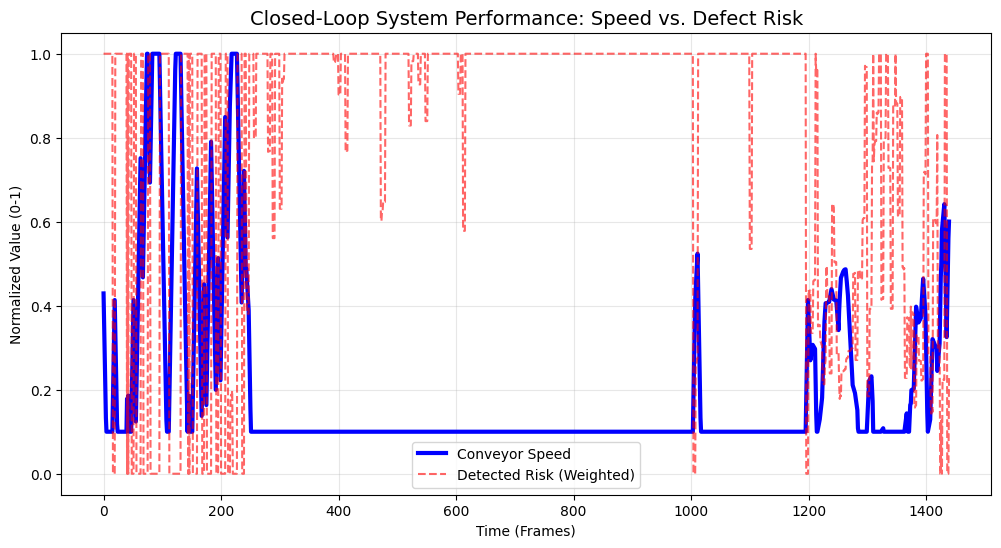

The plot is saved in: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/speed_analysis.png


In [27]:

plt.figure(figsize=(12, 6))

plt.plot(history_speed, label='Conveyor Speed', color='blue', linewidth=3)
plt.plot(history_risk, label='Detected Risk (Weighted)', color='red', alpha=0.6, linestyle='--')

plt.title('Closed-Loop System Performance: Speed vs. Defect Risk', fontsize=14)
plt.xlabel('Time (Frames)')
plt.ylabel('Normalized Value (0-1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(SAVE_PLOT_PATH)
plt.show()

print(f"The plot is saved in: {SAVE_PLOT_PATH}")

# RL

In [28]:
import numpy as np
import pickle
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
import skfuzzy as fuzz
from skfuzzy import control as ctrl

INPUT_VIDEO = "/content/drive/MyDrive/FINAL_Project/simulated_video/raw_simulation.mp4"
MODEL_PATH = "/content/drive/MyDrive/FINAL_Project/Training_Results/YOLO_final/weights/best.pt"


RL_MODEL_SAVE_PATH = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl"
EPISODES = 100

model = YOLO(MODEL_PATH)



class HybridRLAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.93):
        self.q_table = np.zeros((3, 3, 3))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

        self.actions = {0: -0.1, 1: 0.0, 2: 0.1}

    def get_state(self, fuzzy_output, current_speed):
        if fuzzy_output < -0.1: fuzzy_state = 0
        elif fuzzy_output > 0.1: fuzzy_state = 2
        else: fuzzy_state = 1

        if current_speed < 0.3: speed_state = 0
        elif current_speed < 0.7: speed_state = 1
        else: speed_state = 2

        return (fuzzy_state, speed_state)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 3)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value

def calculate_reward_aggressive(speed, risk, action, fuzzy_suggestion):
    reward = 0
    reward += speed * 100

    if risk > 0.4:
        penalty = (risk * speed) * 300
        reward -= penalty

    if fuzzy_suggestion < -0.1: sugg_idx = 0
    elif fuzzy_suggestion > 0.1: sugg_idx = 2
    else: sugg_idx = 1

    if action == sugg_idx:
        reward += 50
    else:
        reward -= 50

    return reward

RISK_FACTORS = {0: 1.0, 1: 0.9, 2: 0.6, 3: 0.8, 4: 0.5, 5: 0.2}
def calculate_weighted_risk(results, img_shape):
    h, w = img_shape[:2]
    total_weighted_risk = 0
    confidences = []
    if len(results.boxes) == 0: return 0.0, 1.0
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        normalized_area = ((x2 - x1) * (y2 - y1)) / (h * w)
        cls_id = int(box.cls)
        total_weighted_risk += (normalized_area * RISK_FACTORS.get(cls_id, 0.5)) * 10
        confidences.append(float(box.conf))
    return min(total_weighted_risk, 1.0), sum(confidences) / len(confidences)

def apply_motion_blur(image, speed):
    factor = 20
    kernel_size = int(speed * factor)
    if kernel_size < 1: return image
    kernel_motion_blur = np.zeros((kernel_size, kernel_size))
    kernel_motion_blur[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel_motion_blur /= kernel_size
    return cv2.filter2D(image, -1, kernel_motion_blur)



In [29]:
if os.path.exists(RL_MODEL_SAVE_PATH):
    try:
        os.remove(RL_MODEL_SAVE_PATH)
        print("The previous version of model has been deleted.")
    except OSError:
        print("couldn't remove the previous model. The new model will be overwrited")

fuzzy_brain = AdvancedFuzzyController()
rl_agent = HybridRLAgent()

print(f"Train hybrid RL model and save in: {RL_MODEL_SAVE_PATH}")

cap_check = cv2.VideoCapture(INPUT_VIDEO)
total_frames = int(cap_check.get(cv2.CAP_PROP_FRAME_COUNT))
cap_check.release()

for episode in range(EPISODES):
    cap = cv2.VideoCapture(INPUT_VIDEO)
    current_speed = 0.5
    total_reward = 0

    ret, frame = cap.read()
    if not ret: break

    results = model(frame, conf=0.25, verbose=False)[0]
    risk, conf = calculate_weighted_risk(results, frame.shape)
    fuzzy_suggestion = fuzzy_brain.compute(risk, conf)
    state = rl_agent.get_state(fuzzy_suggestion, current_speed)

    cached_risk, cached_conf = risk, conf

    for _ in range(total_frames - 1):
        ret, next_frame = cap.read()
        if not ret: break

        action_idx = rl_agent.choose_action(state)
        speed_change = rl_agent.actions[action_idx]
        new_speed = np.clip(current_speed + speed_change, 0.1, 1.0)

        if _ % 3 == 0:
            blurred_frame = apply_motion_blur(next_frame, new_speed)
            results = model(blurred_frame, conf=0.25, verbose=False)[0]
            cached_risk, cached_conf = calculate_weighted_risk(results, next_frame.shape)

        next_risk, next_conf = cached_risk, cached_conf

        reward = calculate_reward_aggressive(new_speed, next_risk, action_idx, fuzzy_suggestion)
        total_reward += reward

        next_fuzzy_suggestion = fuzzy_brain.compute(next_risk, next_conf)
        next_state = rl_agent.get_state(next_fuzzy_suggestion, new_speed)
        rl_agent.learn(state, action_idx, reward, next_state)

        state = next_state
        fuzzy_suggestion = next_fuzzy_suggestion
        current_speed = new_speed

    cap.release()
    rl_agent.epsilon = max(0.05, rl_agent.epsilon * rl_agent.epsilon_decay)

    if (episode+1) % 10 == 0:
        print(f"Ep {episode+1}/{EPISODES} | Reward: {total_reward:.0f} | Epsilon: {rl_agent.epsilon:.2f} | End Speed: {current_speed:.2f}")



Train hybrid RL model and save in: /content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl
Ep 10/100 | Reward: -5859 | Epsilon: 0.48 | End Speed: 0.90
Ep 20/100 | Reward: 23747 | Epsilon: 0.23 | End Speed: 0.50
Ep 30/100 | Reward: 40261 | Epsilon: 0.11 | End Speed: 0.50
Ep 40/100 | Reward: 46182 | Epsilon: 0.05 | End Speed: 0.50
Ep 50/100 | Reward: 47295 | Epsilon: 0.05 | End Speed: 0.50
Ep 60/100 | Reward: 47271 | Epsilon: 0.05 | End Speed: 0.50
Ep 70/100 | Reward: 46264 | Epsilon: 0.05 | End Speed: 0.50
Ep 80/100 | Reward: 47859 | Epsilon: 0.05 | End Speed: 0.50
Ep 90/100 | Reward: 47150 | Epsilon: 0.05 | End Speed: 0.60
Ep 100/100 | Reward: 46596 | Epsilon: 0.05 | End Speed: 0.50


In [30]:
import shutil
if not os.path.exists("/content/drive/MyDrive/FINAL_Project/RL/"):
    os.makedirs("/content/drive/MyDrive/FINAL_Project/RL/")
    print(f"Created new directory: {"/content/drive/MyDrive/FINAL_Project/RL/"}")
else:
    print(f"Directory already exists: {"/content/drive/MyDrive/FINAL_Project/RL/"}")

with open(RL_MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(rl_agent.q_table, f)

print(f"Model saved in: \n{RL_MODEL_SAVE_PATH}")

Created new directory: /content/drive/MyDrive/FINAL_Project/RL/
Model saved in: 
/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl


In [31]:
import pickle
import os


RL_MODEL_PATH = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl"
OUTPUT_RL_VIDEO = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_smart_conveyor.mp4"
SAVE_PLOT_PATH = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_performance.png"

rl_agent = HybridRLAgent()

if os.path.exists(RL_MODEL_PATH):
    with open(RL_MODEL_PATH, 'rb') as f:
        rl_agent.q_table = pickle.load(f)
    print(f"RL model successfully loaded from: {RL_MODEL_PATH}")
else:
    print("Not found.")
    raise FileNotFoundError("Model file not found")

rl_agent.epsilon = 0

cap = cv2.VideoCapture(INPUT_VIDEO)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out_rl = cv2.VideoWriter(OUTPUT_RL_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))

current_speed = 0.5
risk_log, speed_log = [], []

print("Creating Final video...")

ret, frame = cap.read()
if ret:
    results = model(frame, conf=0.25, verbose=False)[0]
    risk, conf = calculate_weighted_risk(results, frame.shape)

    fuzzy_suggestion = fuzzy_brain.compute(risk, conf)
    state = rl_agent.get_state(fuzzy_suggestion, current_speed)

print("Max value in Q-Table:", np.max(rl_agent.q_table))
print("Non-zero elements:", np.count_nonzero(rl_agent.q_table))
while True:
    action_idx = rl_agent.choose_action(state)
    speed_change = rl_agent.actions[action_idx]
    if np.random.rand() < 0.05:
        print(f"Speed: {current_speed:.2f} | Fuzzy: {fuzzy_suggestion:.2f} | RL Action: {action_idx} | Q-Values: {rl_agent.q_table[state]}")

    if np.all(rl_agent.q_table[state] == 0):
        print("All values are zero. weather the model couldn't learn any thing or nothing is loaded from table")
        break
    current_speed = np.clip(current_speed + speed_change, 0.1, 1.0)

    ret, frame = cap.read()
    if not ret: break

    blurred_frame = apply_motion_blur(frame, current_speed)
    results = model(blurred_frame, conf=0.25, verbose=False)[0]
    risk, conf = calculate_weighted_risk(results, frame.shape)

    fuzzy_suggestion = fuzzy_brain.compute(risk, conf)
    state = rl_agent.get_state(fuzzy_suggestion, current_speed)

    annotated = draw_pred(blurred_frame.copy(), results)

    cv2.rectangle(annotated, (0, 0), (width, 100), (0, 0, 0), -1)

    color_speed = (0, 255, 0) if current_speed > 0.7 else (0, 0, 255)
    cv2.putText(annotated, f"SPEED: {current_speed*100:.0f}%", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_speed, 2)

    cv2.putText(annotated, f"RISK: {risk:.2f}", (250, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    fuz_text = "BRAKE" if fuzzy_suggestion < -0.1 else "ACCEL" if fuzzy_suggestion > 0.1 else "HOLD"
    cv2.putText(annotated, f"Fuzzy: {fuz_text}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)

    action_name = ["BRAKE", "HOLD", "ACCEL"][action_idx]
    color_act = (0, 255, 255) if action_name == fuz_text else (0, 0, 255)
    cv2.putText(annotated, f"RL Action: {action_name}", (250, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_act, 2)

    out_rl.write(annotated)

    risk_log.append(risk)
    speed_log.append(current_speed)

cap.release()
out_rl.release()
print(f"Final video saved in: {OUTPUT_RL_VIDEO}")



RL model successfully loaded from: /content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl
Creating Final video...
Max value in Q-Table: 629.4731690727301
Non-zero elements: 27
Speed: 0.10 | Fuzzy: -0.75 | RL Action: 0 | Q-Values: [     408.99      247.56      212.34]
Speed: 0.10 | Fuzzy: -0.79 | RL Action: 0 | Q-Values: [     408.99      247.56      212.34]
Speed: 0.60 | Fuzzy: -0.71 | RL Action: 0 | Q-Values: [     363.56      180.69      206.62]
Speed: 0.50 | Fuzzy: 0.78 | RL Action: 2 | Q-Values: [     352.78      350.54      512.64]
Speed: 1.00 | Fuzzy: 0.78 | RL Action: 2 | Q-Values: [     431.16      480.02      629.47]
Speed: 0.10 | Fuzzy: -0.76 | RL Action: 0 | Q-Values: [     408.99      247.56      212.34]
Speed: 0.50 | Fuzzy: -0.73 | RL Action: 0 | Q-Values: [     363.56      180.69      206.62]
Speed: 0.60 | Fuzzy: 0.78 | RL Action: 2 | Q-Values: [     352.78      350.54      512.64]
Speed: 0.50 | Fuzzy: -0.71 | RL Action: 0 | Q-Values: [     363.56      180.69      20

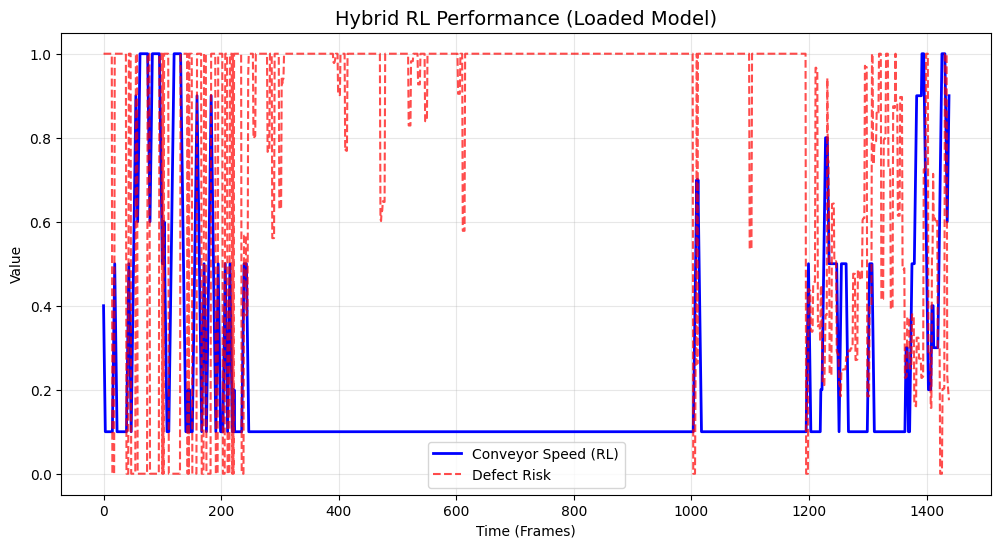

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(speed_log, label='Conveyor Speed (RL)', color='blue', linewidth=2)
plt.plot(risk_log, label='Defect Risk', color='red', linestyle='--', alpha=0.7)
plt.title("Hybrid RL Performance (Loaded Model)", fontsize=14)
plt.xlabel("Time (Frames)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(SAVE_PLOT_PATH)
plt.show()